In [768]:
## package imports ##

import sys
sys.path.append("../PythonScripts")
from preprocessing_utils import preprocess
from utils import save_to_synapse
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import synapseclient as sc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import warnings
import os
from pymatch.Matcher import Matcher
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

warnings.simplefilter("ignore")
sns.set_style("dark")
np.random.seed(100)
%matplotlib inline

In [862]:
## helper function ## 

def annot_phone(params):
    
    if ";" in params:
        params = params.split(";")[0]
    
    if ("iPhone 6+" in params) or ("iPhone 6 Plus" in params):
        return "iPhone 6+"
    else:
        return params
    
def group_spanned(params):
    if (params == "iPhone 6") or (params == "iPhone 6+"):
        return "spanned"
    else:
        return "unspanned"
    
def show_distribution(data, target):
    
    dataV1 = data[data["version"] == "V1"]
    dataV2 = data[data["version"] == "V2"]

    fig, axes = plt.subplots(nrows = 1, ncols = 3)

    sns.distplot(dataV2["age"].dropna(), label = "V2", ax = axes[0])
    sns.distplot(dataV1["age"].dropna(), label = "V1", ax = axes[0])
    axes[0].legend()
    axes[0].set_title("Age distribution of V1 and V2")
    axes[0].grid()
    axes[0].figure.set_size_inches(15,5)

    sns.countplot(data["PD"], hue = data["version"], ax = axes[1])
    axes[1].legend()
    axes[1].set_title("PD distribution of V1 and V2")
    axes[1].grid()
    axes[1].figure.set_size_inches(15,5)
    
    sns.countplot(data["gender"], hue = data["version"], ax = axes[2])
    axes[2].legend()
    axes[2].set_title("gender distribution of V1 and V2")
    axes[2].grid()
    axes[2].figure.set_size_inches(15,5)
    
def PCA_plotter(data, metadata):
    scaler = StandardScaler()
    X = data[[feat for feat in data.columns if ("." in feat)]]
    y = data[["version", "healthCode", "PD"]]
    
    lr = LogisticRegression(random_state = 100)
    gb = GradientBoostingClassifier(random_state = 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y[metadata],
                                                        test_size = 0.2,
                                                        random_state = 100)
    
    gb.fit(X_train, y_train)
    
    print(classification_report(gb.predict(X_test), y_test))
    
    #Plotting the Cumulative Summation of the Explained Variance
    X_scaled = scaler.fit_transform(X)
    pca = PCA().fit(X_scaled)
    pca = PCA(n_components = 3)
    principal_comp = pca.fit_transform(X_scaled)
    principal_df = pd.DataFrame(data = principal_comp)
    principal_df = pd.concat([principal_df, y], axis = 1)
    
    plt.figure(figsize=(8,5))
    sns.scatterplot(principal_df[0], principal_df[1], 
                    hue = principal_df[metadata])
    plt.title("PCA plot")
    plt.ylabel("PC2")
    plt.xlabel("PC1")
    plt.grid()
    plt.show()

In [863]:
## retrieve datasets ##

## syn login
syn = sc.login()


### retrieve version 1 data ###
entityV1 = syn.get("syn21046180")
dataV1   = pd.read_csv(entityV1["path"], index_col = 0)
entityPassive = syn.get("syn21046184")
dataPassive   = pd.read_csv(entityPassive["path"], index_col = 0)
dataV1 = preprocess(dataV1, "max", True)
dataV1["version"] = "V1"


### retrieve data from mPower version 2 ###
### side note: some data are prune to match the distribution to those in V1 ###
entityV2 = syn.get("syn21046181")
dataV2   = pd.read_csv(entityV2["path"], index_col = 0)
dataV2 = preprocess(dataV2, "max", True)
dataV2 = dataV2[dataV2["age"] >= dataV1["age"].min()]
dataV2["version"] = "V2"


### retrieve passive data ####
entityPassive = syn.get("syn21046184")
dataPassive   = pd.read_csv(entityPassive["path"], index_col = 0)


data = pd.concat([dataV1, dataV2]).reset_index()
data["phone_type"] = data["phoneInfo"].apply(annot_phone)

Welcome, aryton tediarjo!



In [872]:
pd.pivot_table(data = data, index = "phone_type", columns = "appVersion", values = "PD", aggfunc = "count")

appVersion,"version 1.0, build 7","version 1.0.5, build 12","version 1.1, build 22","version 1.2, build 31","version 1.3, build 42","version 1.4.1, build 60","version 2.0.1, build 24","version 2.0.2, build 28","version 2.0.3, build 31","version 2.0.3, build 37","version 2.1, build 26"
phone_type,,,,,,,,,,,
"Unknown iPhone (iPhone11,2)",NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,NaN,NaN,NaN
"Unknown iPhone (iPhone11,6)",NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN,NaN,NaN
"Unknown iPhone (iPhone11,8)",NaN,NaN,NaN,NaN,NaN,NaN,1.0,7.0,NaN,NaN,NaN
iPhone 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
iPhone 5C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
iPhone 5S,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,NaN,1.0,NaN
iPhone 5s (GSM),16.0,25.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
iPhone 6,39.0,39.0,4.0,4.0,1.0,3.0,5.0,27.0,NaN,7.0,NaN
iPhone 6+,24.0,16.0,NaN,1.0,6.0,2.0,3.0,9.0,NaN,NaN,NaN


From the pivot table above, we can see that only iPhone 6 and iPhone 6+ have users that spans accross the versions

## Current Distribution of version 1 and version 2

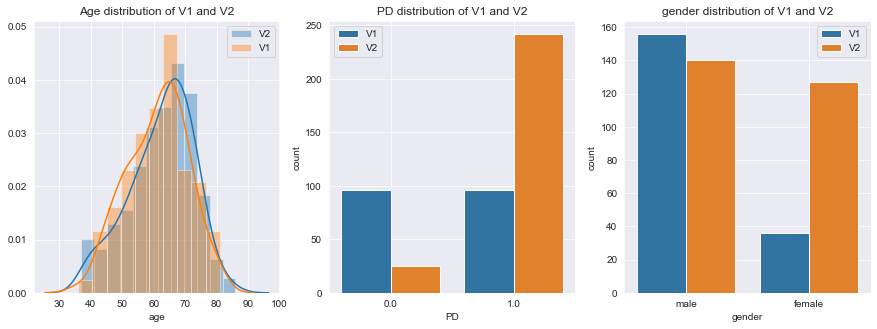

In [864]:
show_distribution(data)

In [865]:
## subsamble based on 6 and 6+ ##
data_subs_6 = data[(data["phone_type"] == "iPhone 6") |
                 (data["phone_type"] == "iPhone 6+")].reset_index(drop = True)
data_all = data.copy()

In [866]:
male_PD_data = data_subs_6[(data_subs_6["gender"] == "male") 
                           & (data_subs_6["PD"] == 1)].reset_index(drop = True)
female_PD_data = data_subs_6[(data_subs_6["gender"] == "female") 
                           & (data_subs_6["PD"] == 1)].reset_index(drop = True)

              precision    recall  f1-score   support

          V1       0.92      0.92      0.92        38
          V2       0.94      0.94      0.94        54

    accuracy                           0.93        92
   macro avg       0.93      0.93      0.93        92
weighted avg       0.93      0.93      0.93        92



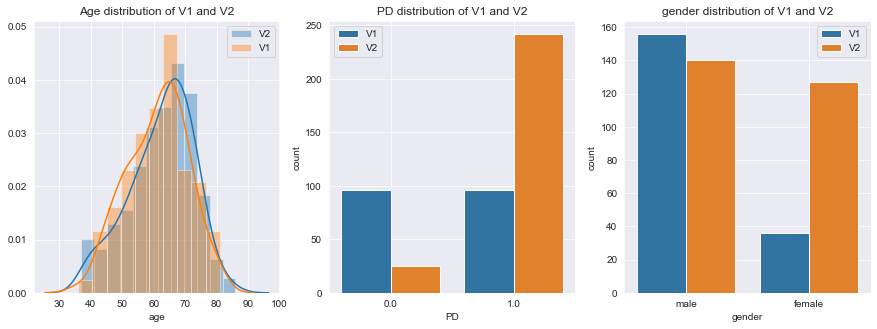

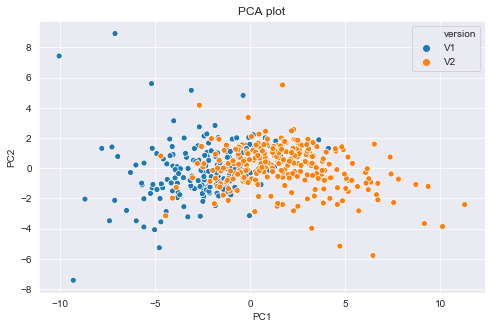

In [887]:
show_distribution(data_all)
PCA_plotter(data_all, "version")

As seen from the PCA plot above, it is apparent that versioning has confounding effects towards our features as the first principal component and the second principal component (which explains most the data's variance) shows that there are separability between the two versions. Additionally, a simple logistic regression is also able to perfectly predict the versions, which is a strong indication that app version is a confounding variable. Therefore, our goal is to convolute the confounding effects of versioning. 

# Use Similarity Metrics to Convolute and Prune the healthCodes

In [868]:

# a function to get K-Nearest Neighbor from user in version 1 to version 2
                                 ##  pseudocode  ##
# for each healthcode in user 1, find K other pair that is similar in "insert here" similarity metrics
# afterwards, filter the data to only pair the healthcode in version 1 to those in version 2
# then collect all the unique healthcodes that is left after the filter

def getKNN_user2user(data, no_neighbors, distance_metrics):
    data_v1 = data[data["version"] == "V1"]
    data_v2 = data[data["version"] == "V2"]
    data = data.set_index("healthCode")
    feat_cols = [feat for feat in data.columns if "." in feat]
    min_max_scaler = MinMaxScaler()
    walking_features = min_max_scaler.fit_transform(data[feat_cols])
    nbrs = NearestNeighbors(n_neighbors = no_neighbors, 
                            algorithm = 'auto', 
                            metric = distance_metrics).fit(walking_features)
    distance, indices = nbrs.kneighbors(walking_features)
    _dict = {}
    _dict["healthCode_ref"] = []
    _dict["healthCode_pair"] = []
    _dict["distance"] = []
    data = data.reset_index()
    for dist, indice in zip(distance, indices):
        for healthcode_idx, _dist in zip(indice[1:], dist[1:]):
            _dict["healthCode_ref"].append(data.ix[indice[0]]["healthCode"])
            _dict["distance"].append(_dist)
            _dict["healthCode_pair"].append(data.ix[healthcode_idx]["healthCode"])
    sim_data = pd.DataFrame(_dict)
    return sim_data.sort_values(by = "distance", ascending = False)

In [890]:
matches = getKNN_user2user(data_all, 5, "cosine").reset_index(drop = True)
v2_list = data[data["version"] == "V2"]["healthCode"].unique()
matches = matches[(~matches["healthCode_ref"].isin(v2_list)) \
        & (matches["healthCode_pair"].isin(v2_list))]
subset_data = data_all[(data_all["healthCode"].isin(matches["healthCode_ref"].unique())) \
                | (data_all["healthCode"].isin(matches["healthCode_pair"].unique()))].reset_index(drop = True)

              precision    recall  f1-score   support

          V1       0.88      0.82      0.85        17
          V2       0.80      0.86      0.83        14

    accuracy                           0.84        31
   macro avg       0.84      0.84      0.84        31
weighted avg       0.84      0.84      0.84        31



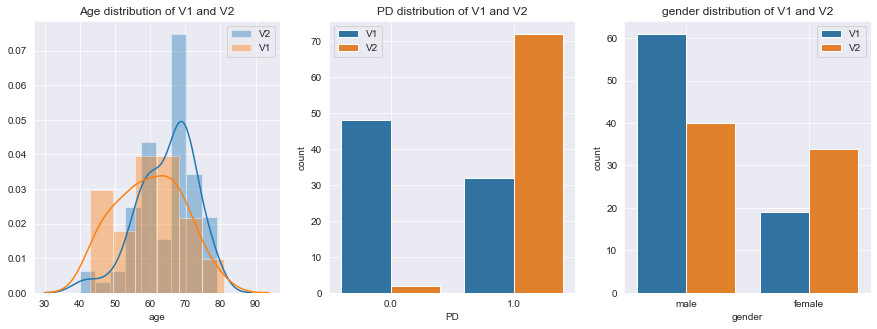

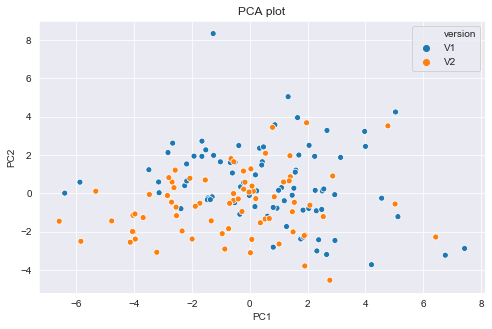

In [891]:
show_distribution(subset_data)
PCA_plotter(subset_data, "version")

              precision    recall  f1-score   support

          V1       0.83      0.83      0.83         6
          V2       0.88      0.88      0.88         8

    accuracy                           0.86        14
   macro avg       0.85      0.85      0.85        14
weighted avg       0.86      0.86      0.86        14



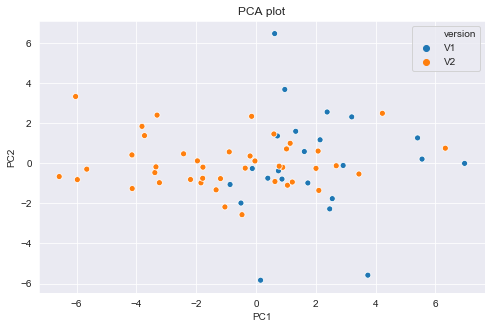

In [886]:
PCA_plotter(subset_data[subset_data["gender"] == "female"].reset_index(), "version")

The graph above shows that by pruning based on similarities, we are able to convolute the separation between the features, additionally, we can see that our logistic regression prediction performance was not as good as the ones before the healthcode pruning. 

# Optimal parameters for convoluting the version confounding effects